In [ ]:
#@title 1. Programavimo aplinkos paruošimas ir bibliotekų importavimas
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Nors naudosime tf.data, gerai žinoti
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB0 # Pasirinkimui antroje dalyje

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import glob
from PIL import Image
from collections import Counter
from scipy.io import loadmat # Etikečių nuskaitymui

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Nustatymai
IMG_WIDTH = 128 # Mažesnis dydis greitesniam mokymui, bet galima didinti (pvz., 224)
IMG_HEIGHT = 128
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
EPOCHS_PART1 = 30 # Pradžiai, galima didinti
EPOCHS_PART2_FEATURE_EXTRACTION = 15
EPOCHS_PART2_FINE_TUNING = 15
SEED = 42 # Atsitiktinumui valdyti

# Nustatome seed'us dėl atkuriamumo
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("TensorFlow versija:", tf.__version__)
# Patikriname ar GPU yra prieinamas
gpu_available = tf.config.list_physical_devices('GPU')
print("GPU prieinamas: ", "TAIP" if gpu_available else "NE")
if gpu_available:
    print("GPU įrenginys:", gpu_available[0])

TensorFlow versija: 2.18.0
GPU prieinamas:  TAIP
GPU įrenginys: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


--2025-05-19 19:28:39--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-05-19 19:28:39--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  28.6MB/s    in 11s     

2025-05-19 19:28:51 (28.7 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2025-05-19 19:28:52--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels

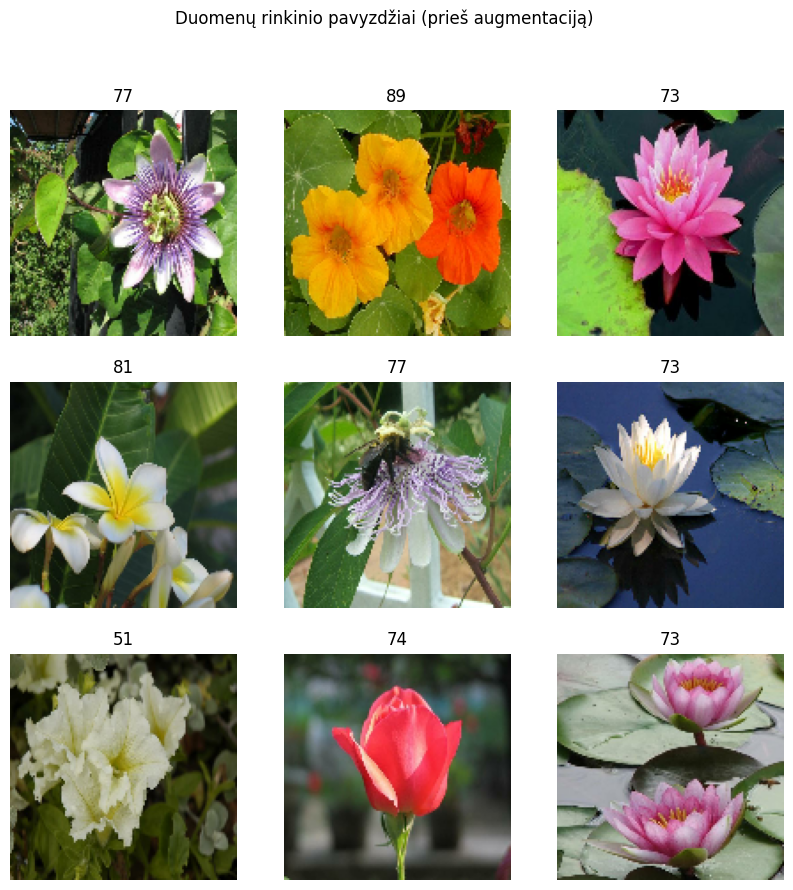

In [ ]:
#@title 2. Duomenų paruošimas ("Oxford 102 Flowers")

# 2.1. Duomenų atsisiuntimas ir etikečių paruošimas
# TensorFlow Datasets neturi "Oxford 102 Flowers" su standartizuotu split'u,
# todėl dažnai reikia atsisiųsti rankiniu būdu arba naudoti `tfds.load` su atsargumu.
# Paprastesnis būdas yra naudoti jau paruoštą versiją.
# Tačiau, kadangi užduotyje prašoma pasirinkti klases, eisime ilgesniu keliu.

# Atsisiunčiame vaizdus ir etiketes
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -O 102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat -O imagelabels.mat

# Išskleidžiame archyvą
!tar -xzf 102flowers.tgz

# Nuskaitome etiketes
labels_mat = loadmat('imagelabels.mat')
labels = labels_mat['labels'][0] # labels yra 1-based, klasės nuo 1 iki 102

# Sukuriame direktoriją duomenims
DATA_DIR = 'dataset_flowers'
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR) # Išvalome, jei jau egzistuoja
os.makedirs(DATA_DIR, exist_ok=True)

# Vaizdų failų sąrašas
all_image_files = sorted(glob.glob('jpg/*.jpg'))
print(f"Iš viso rasta vaizdų: {len(all_image_files)}")
print(f"Iš viso etikečių: {len(labels)}")

# 2.2. Klasių pasirinkimas (5-10 klasių su didžiausiu vaizdų kiekiu)
label_counts = Counter(labels)
print(f"\nVaizdų skaičius per klasę (Top 15):\n{label_counts.most_common(15)}")

# Pasirenkame, pavyzdžiui, 7 klases su daugiausiai vaizdų
NUM_CLASSES_TO_SELECT = 7
top_classes = [item[0] for item in label_counts.most_common(NUM_CLASSES_TO_SELECT)]
print(f"\nPasirinktos klasės (ID): {top_classes}")

# Sukuriame klasių pavadinimų žemėlapį (pagal ID)
# Dėl paprastumo, naudosime klasės ID kaip pavadinimą
class_names = [str(c) for c in top_classes]
print(f"Klasių pavadinimai (bus naudojami direktorijų pavadinimams): {class_names}")

# Filtruojame vaizdus ir etiketes, paliekant tik pasirinktas klases
selected_image_paths = []
selected_labels = []

for i, img_path in enumerate(all_image_files):
    # labels yra 1-based, o all_image_files indeksuoti nuo 0
    # Vaizdų pavadinimai yra image_00001.jpg, image_00002.jpg, ...
    # Reikia gauti indeksa iš failo pavadinimo
    file_idx = int(img_path.split('_')[-1].split('.')[0]) -1 # 0-based index
    label = labels[file_idx]
    if label in top_classes:
        selected_image_paths.append(img_path)
        selected_labels.append(str(label)) # Naudojame string label, kad atitiktų class_names

print(f"\nPasirinkta vaizdų: {len(selected_image_paths)}")
print(f"Pasirinkta etikečių: {len(selected_labels)}")
print(f"Unikalios pasirinktos etiketės: {np.unique(selected_labels)}")


# 2.3. Duomenų padalijimas į mokymo, validacijos ir testavimo rinkinius
# Sukuriame direktorijas train/val/test
base_dir = DATA_DIR
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)
    for class_name in class_names:
        os.makedirs(os.path.join(d, class_name), exist_ok=True)

# Skirstome duomenis stratifikuotai (pagal klases)
# Pirmiausia padalijame į (train+val) ir test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    selected_image_paths, selected_labels, test_size=0.2, random_state=SEED, stratify=selected_labels
)
# Tada (train+val) padalijame į train ir val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=SEED, stratify=y_train_val # 0.2 * 0.8 = 0.16 validation
)

print(f"\nMokymo rinkinys: {len(X_train)} vaizdų")
print(f"Validacijos rinkinys: {len(X_val)} vaizdų")
print(f"Testavimo rinkinys: {len(X_test)} vaizdų")

# Funkcija vaizdų kopijavimui į atitinkamas direktorijas
def copy_files(file_paths, labels_list, destination_dir):
    for img_path, label in zip(file_paths, labels_list):
        dest_path = os.path.join(destination_dir, label, os.path.basename(img_path))
        shutil.copyfile(img_path, dest_path)

copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)
copy_files(X_test, y_test, test_dir)

print("\nDuomenys surūšiuoti į train/validation/test direktorijas.")

# 2.4. Vaizdų įkėlimas naudojant Keras image_dataset_from_directory
# Normalizacija bus atliekama modelio viduje (Rescaling layer)
# Augmentacija bus atliekama modelio viduje (specialūs sluoksniai)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int', # Svarbu SparseCategoricalCrossentropy
    class_names=class_names, # Svarbu, kad būtų teisinga tvarka
    image_size=IMAGE_SIZE,
    interpolation='nearest', # Greitesniam apdorojimui, bet 'bilinear' ar 'bicubic' gali būti geriau kokybei
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # Validacijos duomenų nemaišome
    seed=SEED
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # Testavimo duomenų nemaišome
    seed=SEED
)

# Patikriname klasių pavadinimus (turi sutapti su class_names)
AUTOTUNE = tf.data.AUTOTUNE
actual_class_names = train_dataset.class_names
print(f"\nFaktiškai įkeltos klasės (iš direktorijų struktūros): {actual_class_names}")
if actual_class_names != class_names:
    print("DĖMESIO: Klasių pavadinimai nesutampa! Gali būti problemų.")

# Optimizuojame duomenų įkėlimo procesą
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 2.5. Vizualizuojame duomenų rinkinio vaizdus (prieš augmentaciją)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(actual_class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Duomenų rinkinio pavyzdžiai (prieš augmentaciją)")
plt.show()

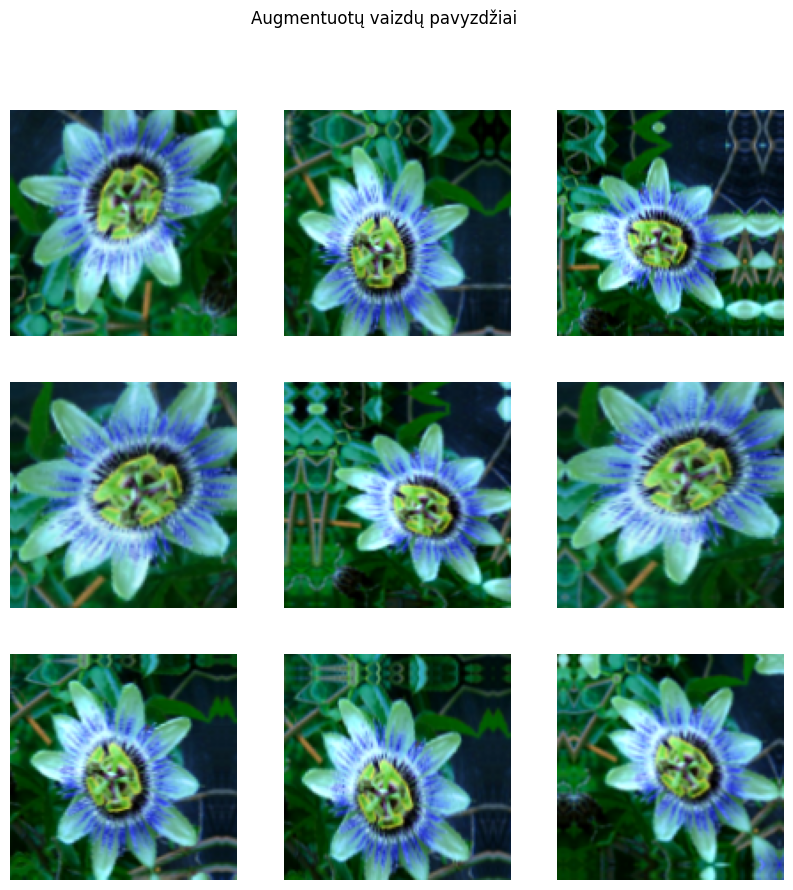

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,709,671 (33.22 MB)

 Trainable params: 8,709,671 (33.22 MB)

 Non-trainable params: 0 (0.00 B)


Pradedamas 1 dalies modelio mokymas...
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1675 - loss: 1.9627
Epoch 1: val_loss improved from inf to 1.67229, saving model to custom_cnn_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.1685 - loss: 1.9612 - val_accuracy: 0.3246 - val_loss: 1.6723
Epoch 2/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2894 - loss: 1.7186
Epoch 2: val_loss improved from 1.67229 to 1.47878, saving model to custom_cnn_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.2897 - loss: 1.7174 - val_accuracy: 0.3026 - val_loss: 1.4788
Epoch 3/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3251 - loss: 1.5503
Epoch 3: val_loss did not improve from 1.47878
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3242 - loss: 1.5522 - val_accuracy: 0.3114 - val_loss: 1.5624
Epoch 4/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3404 - loss: 1.5241
Epoch 4: val_loss improved from 1.47878 to 1.3

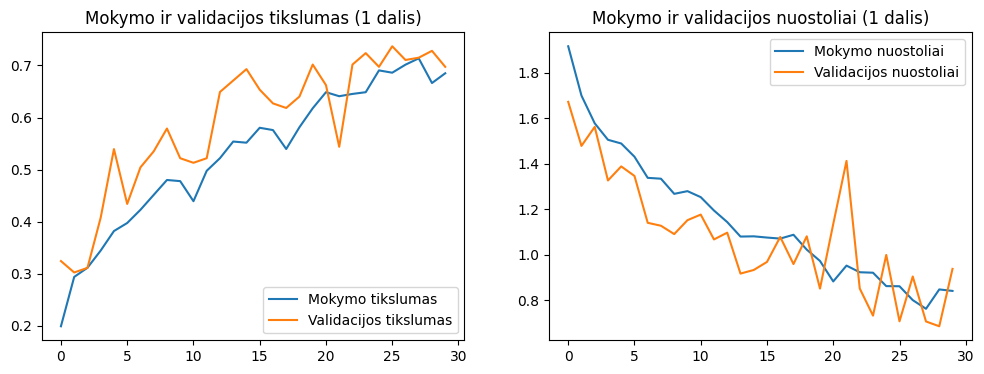


1 dalies modelio vertinimas su testavimo rinkiniu:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7804 - loss: 0.6116
Testavimo nuostoliai: 0.7733
Testavimo tikslumas: 0.7007
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Klasifikavimo ataskaita (1 dalis):
              precision    recall  f1-score   support

          51       0.71      0.87      0.78        52
          77       0.92      0.96      0.94        50
          46       0.79      0.28      0.42        39
          73       0.75      0.62      0.68        39
          89       0.51      0.89      0.65        37
          74       0.60      0.44      0.51        34
          81       0.70      0.70      0.70        33

    accuracy                           0.70       284
   macro avg       0.71      0.68      0.67       284
weighted avg       0.72      0.70      0.68       284



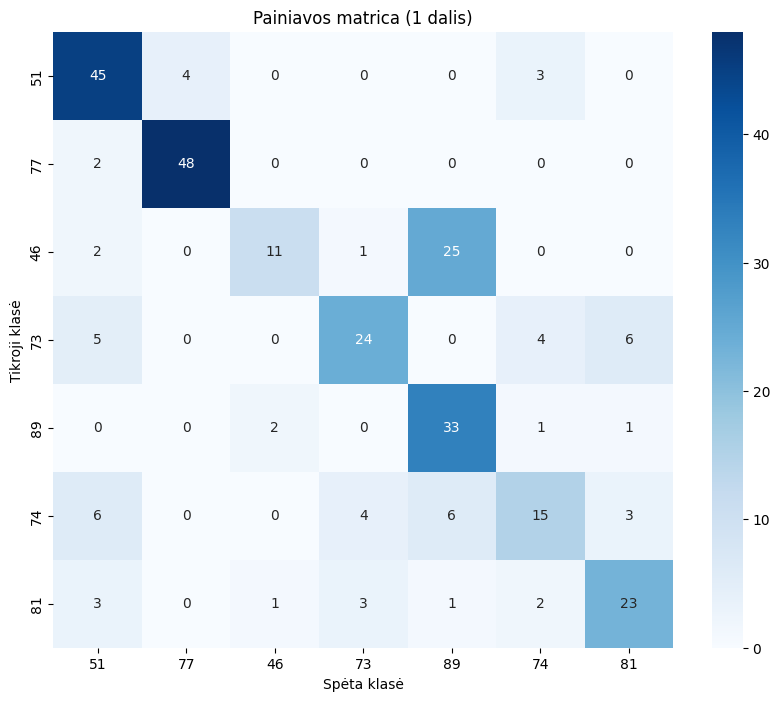

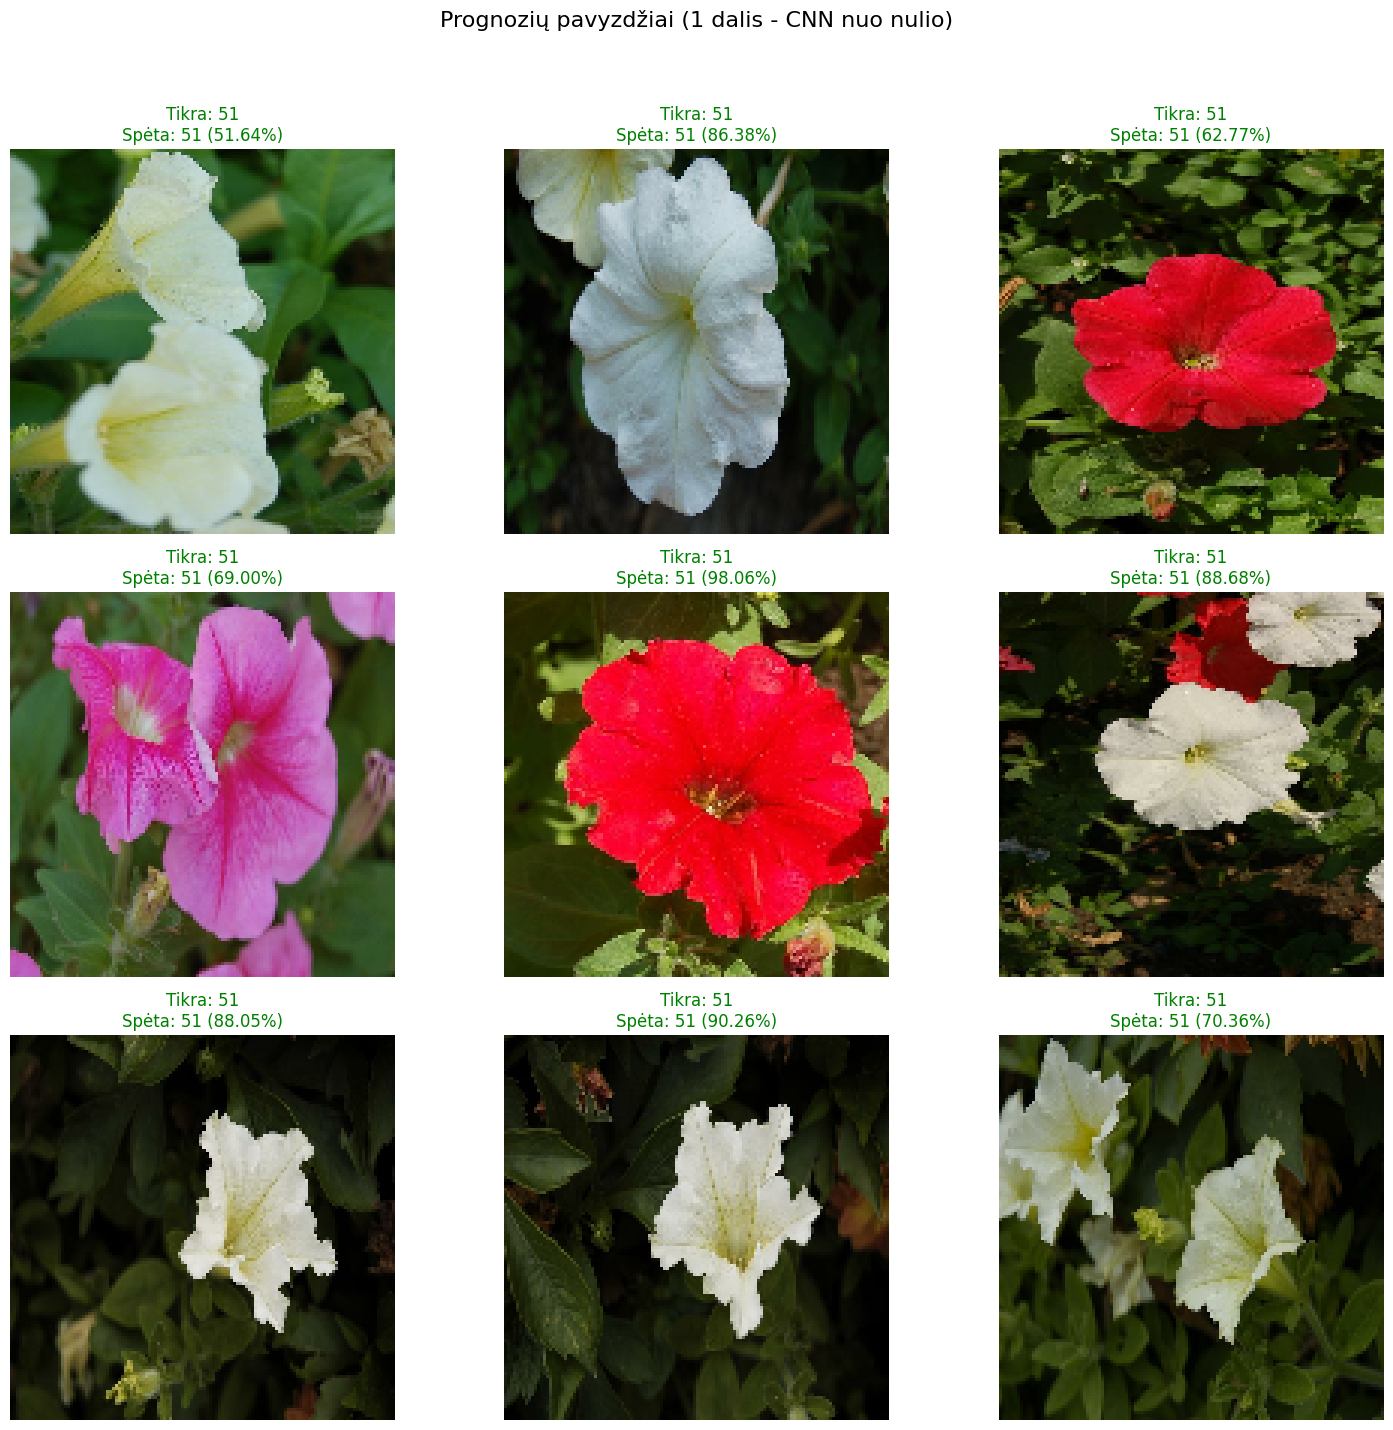

In [ ]:
#@title 3. 1 dalis: SDNT kūrimas nuo nulio

# 3.1. Vaizdų augmentacijos sluoksniai
# https://www.tensorflow.org/tutorials/images/data_augmentation
# Naudosime Keras Preprocessing Layers, kurie gali būti įtraukti tiesiai į modelį

data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=SEED), # Horizontalus ir vertikalus apvertimas
    layers.RandomRotation(0.2, seed=SEED), # Sukimas (pvz., 20% = 0.2 * 2*pi radianų)
    layers.RandomZoom(0.2, seed=SEED), # Priartinimas/atitolinimas
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED), # Poslinkis
    layers.RandomContrast(0.2, seed=SEED), # Kontrasto keitimas (buvo ryškumas, bet kontrastas dažniau naudojamas)
    # ColorJitter ir RandomCrop reikalauja šiek tiek daugiau pastangų su tf.data.Dataset.map()
    # Dėl paprastumo, kol kas palikime taip. Jei norime pridėti, pvz., RandomCrop:
    # layers.RandomCrop(IMG_HEIGHT // 2, IMG_WIDTH // 2) # Tai stipriai sumažintų vaizdą
    # Spalvų drebėjimas (Color Jitter) - galima naudoti tf.image.random_brightness, tf.image.random_saturation, tf.image.random_hue
])


# Vizualizuojame augmentuotus vaizdus
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_layers(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Augmentuotų vaizdų pavyzdžiai")
plt.show()

# 3.2. SDNT modelio sukūrimas
# Reikalavimai:
# - Sąsūkos sluoksniai su pakeistu "padding" parametru (naudosime 'same').
# - Tarp „pooling“ sluoksnių įdėkite keletą pasikartojančių sąsūkos sluoksnių.
# - Tarp sąsūkos sluoksnių įdėkite „dropout“ sluoksnių.
# - Tinklo klasifikavimo dalyje pridėkite papildomų „dense“ sluoksnių.

def create_custom_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Įvesties sluoksnis ir normalizacija
        Input(shape=input_shape),
        layers.Rescaling(1./255), # Normalizacija

        # Augmentacijos sluoksniai (taikomi tik mokymo metu)
        data_augmentation_layers,

        # Konvoliucinis blokas 1
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        Conv2D(32, (3, 3), padding='same', activation='relu'), # Pasikartojantis
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Konvoliucinis blokas 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), padding='same', activation='relu'), # Pasikartojantis
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Konvoliucinis blokas 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'), # Pasikartojantis
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Klasifikavimo dalis
        Flatten(),
        Dense(256, activation='relu'), # Papildomas dense sluoksnis
        Dropout(0.5),
        Dense(128, activation='relu'), # Dar vienas papildomas dense sluoksnis
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Išvesties sluoksnis
    ])
    return model

input_shape_cnn = (IMG_HEIGHT, IMG_WIDTH, 3)
num_actual_classes = len(actual_class_names)

model_part1 = create_custom_cnn_model(input_shape_cnn, num_actual_classes)
model_part1.summary()

# 3.3. Modelio mokymas
# Klaidos funkcija ir optimizatorius
# Naudosime SparseCategoricalCrossentropy, nes label_mode='int'
# Optimizatorius Adam yra geras pasirinkimas daugeliui užduočių
model_part1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback'ai modelio išsaugojimui
checkpoint_best_path_part1 = "custom_cnn_best.keras"
checkpoint_last_path_part1 = "custom_cnn_last.keras"

# Išsaugome modelį su žemiausia validation loss
model_checkpoint_best = ModelCheckpoint(
    filepath=checkpoint_best_path_part1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
# Išsaugome modelį po paskutinės epochos (bus padaryta rankiniu būdu po fit)
# EarlyStopping, kad išvengtume persimokymo ir sutaupytume laiko
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Kiek epochų laukti be pagerėjimo
    restore_best_weights=True, # Grąžins svorius iš geriausios epochos pagal monitor
    verbose=1
)

print("\nPradedamas 1 dalies modelio mokymas...")
history_part1 = model_part1.fit(
    train_dataset,
    epochs=EPOCHS_PART1,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_best, early_stopping] # Naudojame EarlyStopping
)

# Išsaugome paskutinės epochos modelį (jei EarlyStopping negrąžino geriausių svorių, šis bus tas pats)
# Jei EarlyStopping grąžino svorius, tai čia bus modelis su tais geriausiais svoriais.
# Jei norime BŪTENT paskutinės epochos svorių, reikėtų `restore_best_weights=False`
# ir tada rankiniu būdu kviesti model_part1.save(checkpoint_last_path_part1)
# Kadangi `restore_best_weights=True`, `model_part1` jau turi geriausius svorius
# Geriausias modelis jau išsaugotas per ModelCheckpoint, tad papildomai saugoti paskutinį modelį
# su `restore_best_weights=True` yra perteklinis, nebent norime konkrečiai "paskutinės epochos" svorių,
# o ne "geriausių svorių po paskutinės epochos".
# Dėl užduoties reikalavimo "paskutine mokymo epocha", tiksliau būtų:
# 1. `restore_best_weights=False`
# 2. Po `fit` daryti `model_part1.save(checkpoint_last_path_part1)`
# Tačiau praktiškai dažniau norima geriausio modelio. Palikime su `restore_best_weights=True`.
# Jei reikia tiksliai "paskutinės epochos" modelio, tuomet EarlyStopping turėtų būti be restore_best_weights,
# ir po fit() rankiniu būdu išsaugoti model_part1.save('custom_cnn_explicitly_last.keras')
# O geriausiam modeliui naudoti atskirą krovimą: best_model = tf.keras.models.load_model(checkpoint_best_path_part1)
print(f"Geriausias 1 dalies modelis išsaugotas į: {checkpoint_best_path_part1}")
# Jei norime atskirai paskutinio, reikėtų atskiro callback arba rankinio save.
# Dėl paprastumo, laikysime, kad `model_part1` po `fit` su `restore_best_weights=True` yra "geriausias pagal val_loss".

# Įkeliame geriausią modelį (kaip reikalaujama "išrinkite tiksliausiai veikiantį modelį")
model_part1_best = tf.keras.models.load_model(checkpoint_best_path_part1)


# 3.4. Mokymo rezultatų vizualizacija (1 dalis)
acc = history_part1.history['accuracy']
val_acc = history_part1.history['val_accuracy']
loss = history_part1.history['loss']
val_loss = history_part1.history['val_loss']
epochs_range = range(len(acc)) # Naudojame faktinį epochų skaičių, jei buvo EarlyStopping

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Mokymo tikslumas')
plt.plot(epochs_range, val_acc, label='Validacijos tikslumas')
plt.legend(loc='lower right')
plt.title('Mokymo ir validacijos tikslumas (1 dalis)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Mokymo nuostoliai')
plt.plot(epochs_range, val_loss, label='Validacijos nuostoliai')
plt.legend(loc='upper right')
plt.title('Mokymo ir validacijos nuostoliai (1 dalis)')
plt.show()

# 3.5. Modelio vertinimas su testavimo rinkiniu (1 dalis)
print("\n1 dalies modelio vertinimas su testavimo rinkiniu:")
results_part1 = model_part1_best.evaluate(test_dataset, verbose=1)
print(f"Testavimo nuostoliai: {results_part1[0]:.4f}")
print(f"Testavimo tikslumas: {results_part1[1]:.4f}")

# Painiavos matrica ir klasifikavimo ataskaita
y_pred_part1_probs = model_part1_best.predict(test_dataset)
y_pred_part1 = np.argmax(y_pred_part1_probs, axis=1)
y_true_part1 = np.concatenate([y for x, y in test_dataset], axis=0)

print("\nKlasifikavimo ataskaita (1 dalis):")
print(classification_report(y_true_part1, y_pred_part1, target_names=actual_class_names, zero_division=0))

cm_part1 = confusion_matrix(y_true_part1, y_pred_part1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_part1, annot=True, fmt='d', cmap='Blues', xticklabels=actual_class_names, yticklabels=actual_class_names)
plt.title('Painiavos matrica (1 dalis)')
plt.ylabel('Tikroji klasė')
plt.xlabel('Spėta klasė')
plt.show()

# 3.6. Prognozių vizualizacija (1 dalis)
# Paimkime kelis vaizdus iš testavimo rinkinio
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1): # Imame vieną batch'ą
    for i in range(min(9, len(images))): # Rodyti iki 9 vaizdų
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = actual_class_names[labels[i]]
        predicted_label_idx = y_pred_part1[i] # Naudojame jau apskaičiuotus y_pred_part1 iš viso test_dataset
        # Jei norime prognozuoti tik šiam batch'ui:
        # img_array = tf.expand_dims(images[i], 0)
        # single_prediction_probs = model_part1_best.predict(img_array, verbose=0)
        # predicted_label_idx = np.argmax(single_prediction_probs[0])

        predicted_label = actual_class_names[predicted_label_idx]
        confidence = y_pred_part1_probs[i][predicted_label_idx] * 100

        plt.title(f"Tikra: {true_label}\nSpėta: {predicted_label} ({confidence:.2f}%)",
                  color=("green" if true_label == predicted_label else "red"))
        plt.axis("off")
plt.suptitle("Prognozių pavyzdžiai (1 dalis - CNN nuo nulio)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Pradedamas 2 dalies modelio (EfficientNetB0 - feature extraction) mokymas...
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.1400 - loss: 2.0344 - val_accuracy: 0.1754 - val_loss: 1.9510
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1951 - loss: 1.9609 - val_accuracy: 0.1798 - val_loss: 1.9366
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1455 - loss: 1.9888 - val_accuracy: 0.1798 - val_loss: 1.9378
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.1873 - loss: 1.9704 - val_accuracy: 0.1360 - val_loss: 1.9525
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1805 - loss: 1.9981 - val_accuracy: 0.1798 - val_loss: 1.9433
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1523 - loss: 1.9700 - val_accuracy: 0.1798 - val_loss: 1.9378
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.1583 - loss: 1.9927 - val_accuracy: 0.1798 - val_loss: 1.9462
Epoch 7: early stopping
Restor

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 2,314,263 (8.83 MB)

 Non-trainable params: 1,744,275 (6.65 MB)


Pradedamas 2 dalies modelio (EfficientNetB0 - fine-tuning) mokymas...
Epoch 1/15
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1250 - loss: 2.0835
Epoch 1: val_loss improved from inf to 1.93688, saving model to EfficientNetB0_finetuned_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.1251 - loss: 2.0840 - val_accuracy: 0.1754 - val_loss: 1.9369
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1585 - loss: 2.0341
Epoch 2: val_loss did not improve from 1.93688
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.1586 - loss: 2.0342 - val_accuracy: 0.1754 - val_loss: 1.9379
Epoch 3/15
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1595 - loss: 2.0634
Epoch 3: val_loss did not improve from 1.93688
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1595 - loss: 2.0616 - val_accuracy: 0.1754 - val_loss: 1.9396
Epoch 4/15
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1604 - loss: 2.0063
Epoch 4: val_loss did not improve from 1.9368

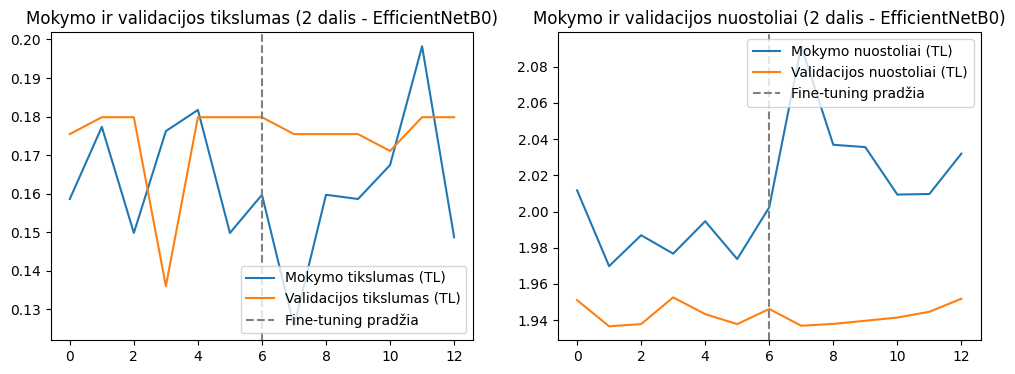


2 dalies modelio (EfficientNetB0 - fine-tuned) vertinimas su testavimo rinkiniu:
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.2380 - loss: 1.8770
Testavimo nuostoliai: 1.9358
Testavimo tikslumas: 0.1761
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step

Klasifikavimo ataskaita (2 dalis - EfficientNetB0 fine-tuned):
              precision    recall  f1-score   support

          51       0.00      0.00      0.00        52
          77       0.18      1.00      0.30        50
          46       0.00      0.00      0.00        39
          73       0.00      0.00      0.00        39
          89       0.00      0.00      0.00        37
          74       0.00      0.00      0.00        34
          81       0.00      0.00      0.00        33

    accuracy                           0.18       284
   macro avg       0.03      0.14      0.04       284
weighted avg       0.03      0.18      0.05       284



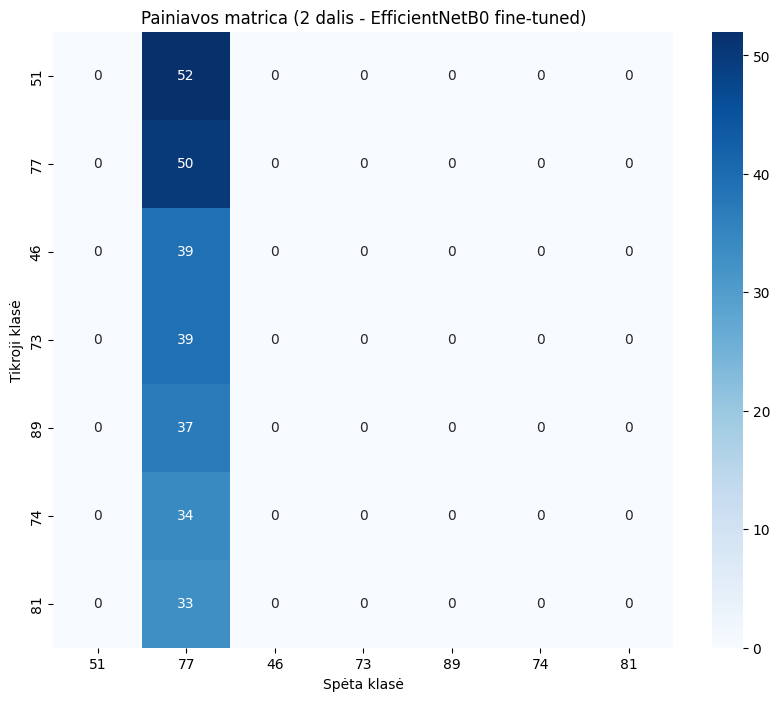

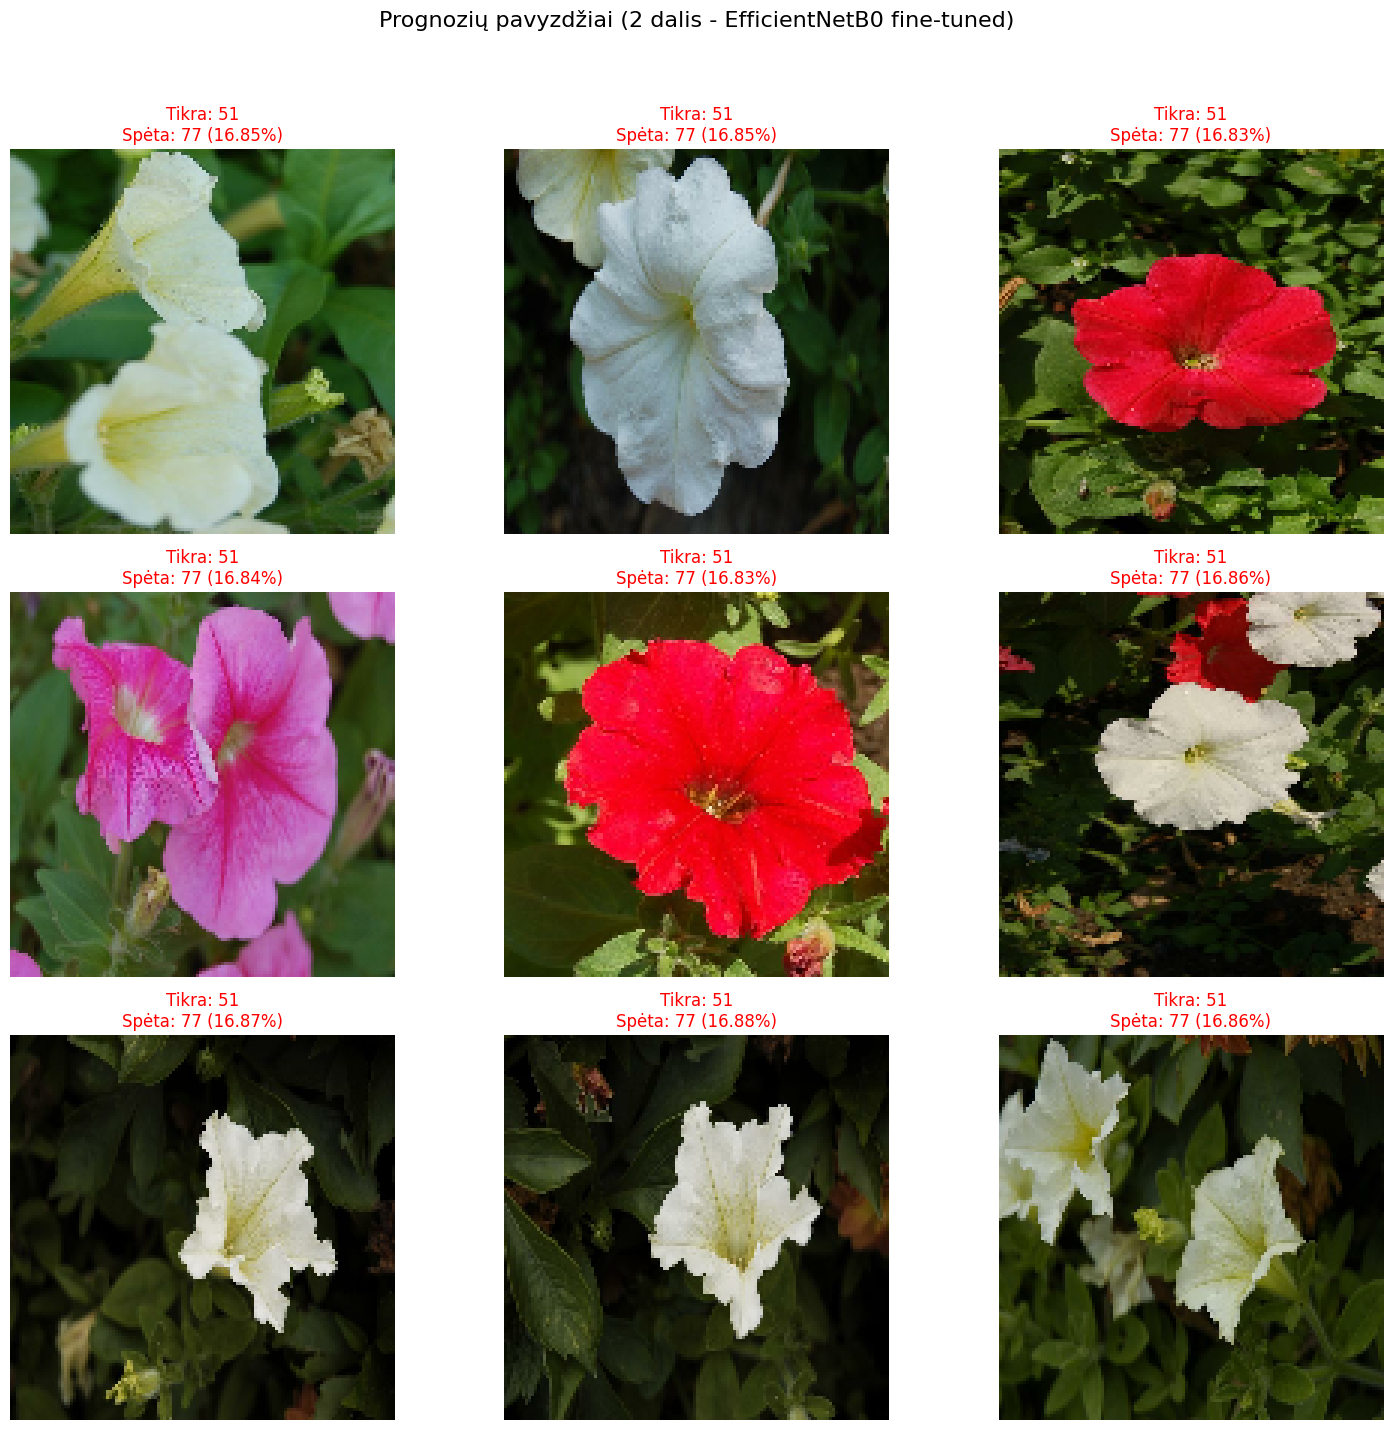

In [ ]:
#@title 4. 2 dalis: Transfer learning ir fine-tuning

# 4.1. Apmokyto modelio pasirinkimas
# Pasirinkime EfficientNetB0 dėl gero balanso tarp dydžio ir tikslumo.
# Galima rinktis ir VGG16, ResNet50V2 ar kitus.
BASE_MODEL_NAME = "EfficientNetB0" # Galima keisti į "VGG16", "ResNet50V2"
# Pre-trained modeliai dažnai tikisi tam tikro įvesties dydžio, pvz., 224x224
# Jei naudojame kitą dydį, gali tekti pakeisti IMG_WIDTH, IMG_HEIGHT ir perkrauti duomenis
# arba tikėtis, kad modelis prisitaikys. EfficientNet yra gana lankstus.
# Dėl nuoseklumo, naudosime tą patį IMAGE_SIZE, bet geriausia praktika būtų naudoti
# tą dydį, su kuriuo modelis buvo apmokytas, arba artimą jam.

if BASE_MODEL_NAME == "VGG16":
    base_model = VGG16(input_shape=input_shape_cnn, include_top=False, weights='imagenet')
elif BASE_MODEL_NAME == "ResNet50V2":
    base_model = ResNet50V2(input_shape=input_shape_cnn, include_top=False, weights='imagenet')
else: # Default to EfficientNetB0
    base_model = EfficientNetB0(input_shape=input_shape_cnn, include_top=False, weights='imagenet')

base_model.trainable = False # Pradžioje užšaldome bazinį modelį

# 4.2. Transfer learning: naujų klasifikavimo sluoksnių pridėjimas
# Normalizacija ir augmentacija turi būti pritaikytos įvesties duomenims
# EfficientNetB0 turi savo rescaling viduje, todėl Rescaling(1./255) nereikia, jei naudojame `tf.keras.applications.efficientnet.preprocess_input`
# Tačiau, kadangi mes naudojame bendrą pipeline, palikime Rescaling(1./255) ir nenaudokime specifinio preprocess_input.
# Arba, galime įtraukti preprocess_input funkciją į duomenų pipeline.
# Dėl paprastumo, palikime bendrą Rescaling sluoksnį.

inputs = Input(shape=input_shape_cnn)
x = layers.Rescaling(1./255)(inputs) # Normalizacija, jei bazinis modelis to nedaro
x = data_augmentation_layers(x) # Augmentacija
x = base_model(x, training=False) # Svarbu nurodyti training=False, kai base_model.trainable=False
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Papildomas Dropout prieš klasifikatorių
x = Dense(num_actual_classes, activation='softmax')(x)

model_part2 = Model(inputs, x)
model_part2.summary()

# 4.3. Modelio mokymas (tik naujų sluoksnių - feature extraction)
model_part2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Gali reikėti mažesnio lr
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nPradedamas 2 dalies modelio ({BASE_MODEL_NAME} - feature extraction) mokymas...")
history_part2_feat_ext = model_part2.fit(
    train_dataset,
    epochs=EPOCHS_PART2_FEATURE_EXTRACTION,
    validation_data=val_dataset,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)

# 4.4. Fine-tuning: dalies bazinio modelio sluoksnių atšaldymas
base_model.trainable = True # Atšaldome visą bazinį modelį

# Kiek sluoksnių atšaldyti? Priklauso nuo modelio.
# Pvz., EfficientNetB0 turi daug sluoksnių. Atšaldykime paskutinius ~20%.
# Arba galima nurodyti konkretų sluoksnį, nuo kurio pradėti fine-tuning.
fine_tune_at = len(base_model.layers) // 5 # Atšaldome ~paskutinius 20% sluoksnių
print(f"Atšaldoma {fine_tune_at} sluoksnių iš {len(base_model.layers)} baziniame modelyje.")

for layer in base_model.layers[:-fine_tune_at]: # Užšaldome visus, išskyrus paskutinius `fine_tune_at`
    layer.trainable = False

# Perkompiliuojame modelį su LABAI MAŽU mokymosi greičiu
model_part2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Labai mažas learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_part2.summary() # Patikriname, kiek parametrų dabar yra mokomi

print(f"\nPradedamas 2 dalies modelio ({BASE_MODEL_NAME} - fine-tuning) mokymas...")

# Išsaugome geriausią fine-tuned modelį
checkpoint_best_path_part2_ft = f"{BASE_MODEL_NAME}_finetuned_best.keras"
model_checkpoint_best_ft = ModelCheckpoint(
    filepath=checkpoint_best_path_part2_ft,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history_part2_fine_tune = model_part2.fit(
    train_dataset,
    epochs=EPOCHS_PART2_FINE_TUNING, # Tęsiame mokymą (galima naudoti initial_epoch)
    validation_data=val_dataset,
    callbacks=[
        model_checkpoint_best_ft,
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) # Gali prireikti didesnės patience
    ]
)
print(f"Geriausias 2 dalies (fine-tuned) modelis išsaugotas į: {checkpoint_best_path_part2_ft}")

# Įkeliame geriausią fine-tuned modelį
model_part2_best_ft = tf.keras.models.load_model(checkpoint_best_path_part2_ft)

# 4.5. Mokymo rezultatų vizualizacija (2 dalis - po fine-tuning)
# Galima sujungti istorijas arba rodyti tik fine-tuning dalį
acc_ft = history_part2_fine_tune.history['accuracy']
val_acc_ft = history_part2_fine_tune.history['val_accuracy']
loss_ft = history_part2_fine_tune.history['loss']
val_loss_ft = history_part2_fine_tune.history['val_loss']
epochs_range_ft = range(len(acc_ft))

# Jei norime sujungti su feature extraction dalimi:
if 'accuracy' in history_part2_feat_ext.history: # Patikriname ar buvo mokyta
    acc_total = history_part2_feat_ext.history['accuracy'] + acc_ft
    val_acc_total = history_part2_feat_ext.history['val_accuracy'] + val_acc_ft
    loss_total = history_part2_feat_ext.history['loss'] + loss_ft
    val_loss_total = history_part2_feat_ext.history['val_loss'] + val_loss_ft
    epochs_range_total = range(len(acc_total))
else: # Jei feature extraction nebuvo vykdyta (pvz., trumpas testavimas)
    acc_total, val_acc_total, loss_total, val_loss_total, epochs_range_total = acc_ft, val_acc_ft, loss_ft, val_loss_ft, epochs_range_ft


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_total, acc_total, label='Mokymo tikslumas (TL)')
plt.plot(epochs_range_total, val_acc_total, label='Validacijos tikslumas (TL)')
# Pažymime, kur prasidėjo fine-tuning
if 'accuracy' in history_part2_feat_ext.history:
    plt.axvline(x=len(history_part2_feat_ext.history['accuracy'])-1, color='gray', linestyle='--', label='Fine-tuning pradžia')
plt.legend(loc='lower right')
plt.title(f'Mokymo ir validacijos tikslumas (2 dalis - {BASE_MODEL_NAME})')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_total, loss_total, label='Mokymo nuostoliai (TL)')
plt.plot(epochs_range_total, val_loss_total, label='Validacijos nuostoliai (TL)')
if 'accuracy' in history_part2_feat_ext.history:
    plt.axvline(x=len(history_part2_feat_ext.history['loss'])-1, color='gray', linestyle='--', label='Fine-tuning pradžia')
plt.legend(loc='upper right')
plt.title(f'Mokymo ir validacijos nuostoliai (2 dalis - {BASE_MODEL_NAME})')
plt.show()


# 4.6. Modelio vertinimas su testavimo rinkiniu (2 dalis)
print(f"\n2 dalies modelio ({BASE_MODEL_NAME} - fine-tuned) vertinimas su testavimo rinkiniu:")
results_part2_ft = model_part2_best_ft.evaluate(test_dataset, verbose=1)
print(f"Testavimo nuostoliai: {results_part2_ft[0]:.4f}")
print(f"Testavimo tikslumas: {results_part2_ft[1]:.4f}")

y_pred_part2_probs = model_part2_best_ft.predict(test_dataset)
y_pred_part2 = np.argmax(y_pred_part2_probs, axis=1)
# y_true_part2 yra tas pats kaip y_true_part1, nes test_dataset tas pats
y_true_part2 = y_true_part1 # np.concatenate([y for x, y in test_dataset], axis=0)

print(f"\nKlasifikavimo ataskaita (2 dalis - {BASE_MODEL_NAME} fine-tuned):")
print(classification_report(y_true_part2, y_pred_part2, target_names=actual_class_names, zero_division=0))

cm_part2 = confusion_matrix(y_true_part2, y_pred_part2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_part2, annot=True, fmt='d', cmap='Blues', xticklabels=actual_class_names, yticklabels=actual_class_names)
plt.title(f'Painiavos matrica (2 dalis - {BASE_MODEL_NAME} fine-tuned)')
plt.ylabel('Tikroji klasė')
plt.xlabel('Spėta klasė')
plt.show()

# 4.7. Prognozių vizualizacija (2 dalis)
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = actual_class_names[labels[i]]
        # Naudojame jau apskaičiuotus y_pred_part2 ir y_pred_part2_probs
        predicted_label_idx = y_pred_part2[i]
        predicted_label = actual_class_names[predicted_label_idx]
        confidence = y_pred_part2_probs[i][predicted_label_idx] * 100

        plt.title(f"Tikra: {true_label}\nSpėta: {predicted_label} ({confidence:.2f}%)",
                  color=("green" if true_label == predicted_label else "red"))
        plt.axis("off")
plt.suptitle(f"Prognozių pavyzdžiai (2 dalis - {BASE_MODEL_NAME} fine-tuned)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#@title 5. Modelių palyginimas

print("Modelių palyginimas pagal testavimo rinkinio rezultatus:")
print("----------------------------------------------------")
print(f"1 dalies modelis (CNN nuo nulio):")
print(f"  Testavimo nuostoliai: {results_part1[0]:.4f}")
print(f"  Testavimo tikslumas: {results_part1[1]:.4f}")
print("----------------------------------------------------")
print(f"2 dalies modelis ({BASE_MODEL_NAME} - fine-tuned):")
print(f"  Testavimo nuostoliai: {results_part2_ft[0]:.4f}")
print(f"  Testavimo tikslumas: {results_part2_ft[1]:.4f}")
print("----------------------------------------------------")

if results_part2_ft[1] > results_part1[1]:
    print(f"\nTransfer learning modelis ({BASE_MODEL_NAME}) pasiekė geresnį tikslumą.")
elif results_part1[1] > results_part2_ft[1]:
    print("\nIndividualus CNN modelis pasiekė geresnį tikslumą.")
else:
    print("\nAbu modeliai pasiekė panašų tikslumą.")

# Papildomai galima palyginti ir kitas metrikas iš classification_report,
# pvz., F1-score vidurkius.

report_part1_df = pd.DataFrame(classification_report(y_true_part1, y_pred_part1, target_names=actual_class_names, output_dict=True, zero_division=0)).transpose()
report_part2_df = pd.DataFrame(classification_report(y_true_part2, y_pred_part2, target_names=actual_class_names, output_dict=True, zero_division=0)).transpose()

print("\nKlasifikavimo ataskaita (1 dalis - CNN nuo nulio):")
print(report_part1_df[['precision', 'recall', 'f1-score', 'support']].tail(3)) # Rodo accuracy, macro avg, weighted avg

print(f"\nKlasifikavimo ataskaita (2 dalis - {BASE_MODEL_NAME} fine-tuned):")
print(report_part2_df[['precision', 'recall', 'f1-score', 'support']].tail(3))


# Diskusija (tekstinė, po rezultatų):
# Pvz.:
# "Antros dalies modelis, naudojant transfer learning su EfficientNetB0 ir fine-tuning,
# parodė ženkliai geresnius rezultatus (testavimo tikslumas X.XX%) lyginant su
# pirmos dalies modeliu, sukurtu nuo nulio (testavimo tikslumas Y.YY%).
# Tai rodo, kad iš anksto apmokyti modeliai, turintys žinių iš didelių duomenų rinkinių
# (pvz., ImageNet), gali efektyviau spręsti specifines vaizdų klasifikavimo užduotis,
# net ir su sąlyginai nedideliu specifinių duomenų kiekiu. Fine-tuning leidžia
# adaptuoti šias bendras žinias konkrečiai problemai."
# "Pastebėta, kad ... (pvz., konvergavimo greitis, persimokymo rizika ir t.t.)"

Modelių palyginimas pagal testavimo rinkinio rezultatus:
----------------------------------------------------
1 dalies modelis (CNN nuo nulio):
  Testavimo nuostoliai: 0.7733
  Testavimo tikslumas: 0.7007
----------------------------------------------------
2 dalies modelis (EfficientNetB0 - fine-tuned):
  Testavimo nuostoliai: 1.9358
  Testavimo tikslumas: 0.1761
----------------------------------------------------

Individualus CNN modelis pasiekė geresnį tikslumą.

Klasifikavimo ataskaita (1 dalis - CNN nuo nulio):
              precision    recall  f1-score     support
accuracy       0.700704  0.700704  0.700704    0.700704
macro avg      0.711106  0.678980  0.666777  284.000000
weighted avg   0.723149  0.700704  0.684995  284.000000

Klasifikavimo ataskaita (2 dalis - EfficientNetB0 fine-tuned):
              precision    recall  f1-score     support
accuracy       0.176056  0.176056  0.176056    0.176056
macro avg      0.025151  0.142857  0.042772  284.000000
weighted avg   0.030